### Загрузка необходимых данных и библиотек в рабочую среду

In [61]:
import bz2
import nltk
import json
import regex
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy import sparse
from fuzzywuzzy import process
from collections import Counter
from nltk.corpus import stopwords
from gensim import corpora, models
from pymorphy2 import MorphAnalyzer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [00:46, 4305.41it/s]


### Часть 1. Анализ текстов

#### 1. Посчитайте количество отзывов в разных городах и на разные банки

In [4]:
df = pd.DataFrame(responses)

In [5]:
df.head(2)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN


Посмотрим количество отзывов в разных городах и на разные банки напрямую без обработки данных

In [6]:
df['city'].value_counts()

city
г. Москва                               55354
г. Санкт-Петербург                      14342
г. Екатеринбург                          2337
г. Новосибирск                           2300
г. Нижний Новгород                       1976
                                        ...  
г. г.Калуга                                 1
г. ВЕЛИКИЕ ЛУКИ                             1
г. всеволожск                               1
г. сейчас                                   1
г. Краснодарский край, ст.Павловская        1
Name: count, Length: 5823, dtype: int64

In [7]:
df['bank_name'].value_counts()

bank_name
Сбербанк России     26327
Альфа-Банк          10224
ВТБ 24               8185
Русский Стандарт     7943
Хоум Кредит Банк     7549
                    ...  
Сиббизнесбанк           1
Донбанк                 1
Потенциал               1
Ури Банк                1
БайкалИнвестБанк        1
Name: count, Length: 670, dtype: int64

In [8]:
list(df['city'].unique())

['г. Москва',
 'г. Новосибирск',
 'г. Ставрополь',
 'г. Челябинск',
 'г. Волгоград',
 'г. Пермь',
 'г. Ростов-на-Дону',
 'г. Воронеж',
 'г. Таганрог (Ростовская обл.)',
 'г. Санкт-Петербург',
 'г. Конаково',
 'г. Мурманск',
 'г. Волгодонск (Ростовская обл.)',
 'г. Большеречье',
 'г. Одинцово (Московская обл.)',
 'г. Салават (Республика Башкортостан)',
 'г. Краснодар',
 'г. Кострома',
 'г. Нижний Новгород',
 'г. Орел',
 'г. Саратов',
 'г. Казань',
 'г. Реутов (Московская обл.)',
 'г. Ульяновск',
 'г. Красноярск',
 'г. Хабаровск',
 'г. Магнитогорск (Челябинская обл.)',
 'г. Фролово (Волгоградская обл.)',
 'г. Новочеркасск',
 'г. Чита',
 'г. таганрог',
 'г. Йошкар-Ола',
 'г. Нижний Тагил',
 'г. Ханты-Мансийск',
 'г. Россия',
 'г. Липецк',
 'г. Нижнекамск (Республика Татарстан)',
 'г. Тюмень',
 'г. Москва, Санкт-Петербург',
 'г. Кизел',
 'г. Мончегорск',
 'г. Екатеринбург',
 'г. Омск',
 'г. Астрахань',
 'г. Псков',
 'г. Сочи (Краснодарский край)',
 'г. Комсомольск на амуре',
 'г. Нижний Та

Видим, что одни и те же города в разных отзывах могут быть по-разному записаны. Попробуем избежать этого и привести обозначение города к нормальной форме

In [10]:
# Загрузим базу данных со списком городов России
cities = pd.read_json('russian-cities.json')
cities.head(3)

,coords,district,name,population,subject
0,"{'lat': '52.65', 'lon': '90.083333333333'}",Сибирский,Абаза,12272,Хакасия
1,"{'lat': '53.71667', 'lon': '91.41667'}",Сибирский,Абакан,184769,Хакасия
2,"{'lat': '53.68333', 'lon': '53.65'}",Приволжский,Абдулино,17274,Оренбургская область


In [20]:
# Сразу удалим те отзывы, в которых город указан не был
data_without_nan_city = df.copy()
data_without_nan_city = data_without_nan_city.dropna(subset=['city'])

# Ограничимся 10000 записей в целях ускорения выполнения кода
data_without_nan_city = data_without_nan_city.head(10000)

In [15]:
# Запишем функцию для нормализации названий городов с помощью fuzzywuzzy
def normalize_city(city, cities_list):
    return process.extractOne(city, cities_list)[0]

In [21]:
data_without_nan_city['normalized_city'] = ''
for i, x in tqdm(enumerate(data_without_nan_city['city'])):
    data_without_nan_city.loc[i, 'normalized_city'] = normalize_city(x, cities['name'])

10000it [07:11, 23.17it/s]


In [22]:
data_without_nan_city.to_csv('data_without_nan_city.csv', index=False, encoding='utf-8-sig')

In [23]:
data_without_nan_city.head(3)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,normalized_city
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN,Москва
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN,Новосибирск
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN,Москва


Снова найдём количество отзывов в разных городах и на разные банки 

In [24]:
data_without_nan_city['normalized_city'].value_counts().to_dict()

{'Москва': 4598,
 'Санкт-Петербург': 943,
 'Екатеринбург': 180,
 'Новосибирск': 161,
 'Нижний Новгород': 141,
 'Ростов-на-Дону': 130,
 'Самара': 127,
 'Омск': 117,
 'Челябинск': 108,
 'Краснодар': 104,
 'Воронеж': 103,
 'Ставрополь': 96,
 'Казань': 95,
 'Красноярск': 94,
 'Волгоград': 86,
 'Саратов': 84,
 'Иркутск': 79,
 'Пермь': 77,
 'Уфа': 75,
 'Хабаровск': 61,
 'Тюмень': 57,
 'Ярославль': 56,
 'Барнаул': 55,
 'Калининград': 53,
 'Арск': 51,
 'Ульяновск': 48,
 'Тула': 44,
 'Тверь': 44,
 'Рязань': 39,
 'Липецк': 38,
 'Оренбург': 38,
 'Владивосток': 35,
 'Иваново': 34,
 'Белгород': 34,
 'Чебоксары': 31,
 'Мурманск': 31,
 'Кемерово': 30,
 'Архангельск': 30,
 'Пенза': 29,
 'Владимир': 28,
 'Набережные Челны': 28,
 'Вологда': 28,
 'Ижевск': 26,
 'Подольск': 25,
 'Киров': 24,
 'Курск': 24,
 'Улан-Удэ': 24,
 'Смоленск': 23,
 'Тольятти': 23,
 'Брянск': 23,
 'Астрахань': 22,
 'Магнитогорск': 21,
 'Балашиха': 21,
 'Сургут': 21,
 'Люберцы': 21,
 'Орёл': 21,
 'Таганрог': 21,
 'Мытищи': 21,
 'Кур

In [25]:
data_without_nan_city['bank_name'].value_counts().to_dict()

{'Сбербанк России': 1696,
 'Альфа-Банк': 709,
 'ВТБ 24': 616,
 'Русский Стандарт': 560,
 'Хоум Кредит Банк': 538,
 'Тинькофф Банк': 500,
 'Восточный Экспресс Банк': 398,
 'Московский Кредитный Банк': 246,
 'ОТП Банк': 244,
 'Национальный Банк «Траст»': 242,
 'Бинбанк': 204,
 'Промсвязьбанк': 195,
 'Связной Банк': 186,
 'Банк Москвы': 184,
 'Киви Банк': 174,
 'Ренессанс Кредит': 174,
 'Ханты-Мансийский банк Открытие': 148,
 'Сетелем Банк': 124,
 'Совкомбанк': 120,
 'Лето Банк': 119,
 'Райффайзенбанк': 117,
 'Югра': 116,
 'АйМаниБанк': 104,
 'Авангард': 96,
 'МТС Банк': 96,
 'ЮниКредит Банк': 88,
 'Росбанк': 87,
 'Ситибанк': 84,
 'Кредит Европа Банк': 75,
 'Уральский Банк Реконструкции и Развития': 70,
 'БИНБАНК кредитные карты': 70,
 'Россельхозбанк': 69,
 'Русславбанк': 68,
 'Яндекс.Деньги': 60,
 'МДМ Банк': 60,
 'Московский Областной Банк': 54,
 'Транспортный': 51,
 'МАСТ-Банк': 41,
 'Финансовый Стандарт': 41,
 'РосинтерБанк': 37,
 'СКБ-Банк': 31,
 'Юниаструм Банк': 29,
 'Уралсиб': 29

In [101]:
# Приведём к более наглядному виду 
review_counts = data_without_nan_city.groupby(['normalized_city', 'bank_name']).size().reset_index(name='review_count')
review_counts.sort_values(by='review_count', ascending=False).reset_index().drop(columns=['index'])

,normalized_city,bank_name,review_count
0,Москва,Сбербанк России,551
1,Москва,Альфа-Банк,335
2,Москва,Тинькофф Банк,305
3,Москва,ВТБ 24,274
4,Москва,Русский Стандарт,256
...,...,...,...
2461,Красноярск,Ренессанс Кредит,1
2462,Красноярск,МТС Банк,1
2463,Красноярск,Ланта-Банк,1
2464,Красноярск,Клиентский,1


#### 2. Постройте гистограммы длин отзывов в символах и в словах

In [59]:
# Получаем список длин отзывов в символах
lengths_chars = [len(resp['text']) for resp in responses]

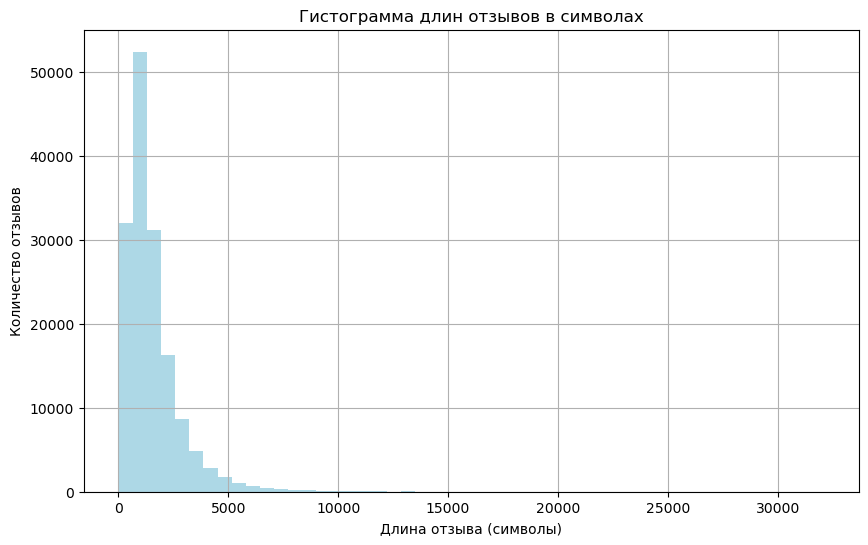

In [60]:
# Строим гистограмму длин отзывов в символах
plt.figure(figsize=(10, 6))
plt.hist(lengths_chars, bins=50, color='lightblue')
plt.xlabel('Длина отзыва (символы)')
plt.ylabel('Количество отзывов')
plt.title('Гистограмма длин отзывов в символах')
plt.grid(True)
plt.show()

In [57]:
# Получаем список длин отзывов в словах
lengths_words = [len(resp['text'].split()) for resp in responses]

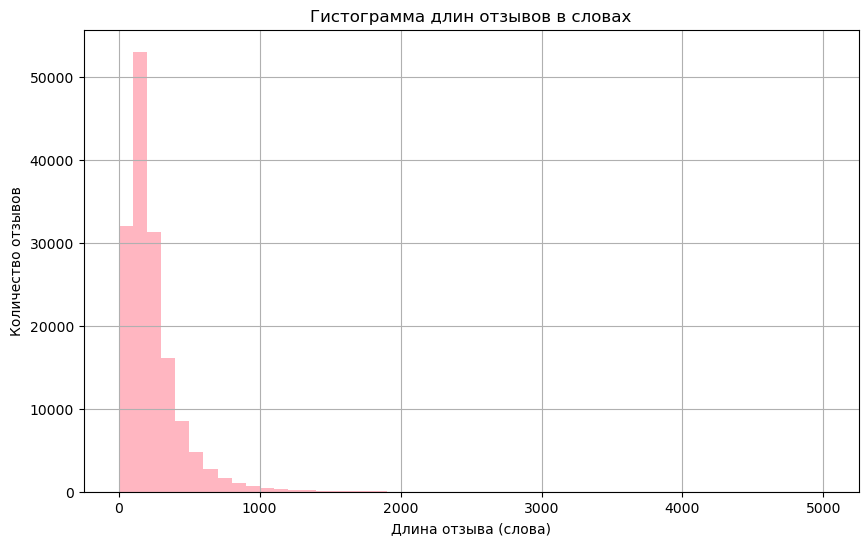

In [58]:
# Строим гистограмму длин отзывов в словах
plt.figure(figsize=(10, 6))
plt.hist(lengths_words, bins=50, color='lightpink')
plt.xlabel('Длина отзыва (слова)')
plt.ylabel('Количество отзывов')
plt.title('Гистограмма длин отзывов в словах')
plt.grid(True)
plt.show()

#### 3. Найдите 10 самых частых:

##### - Слов

In [26]:
# Соберём все тексты отзывов в одну строку
all_texts = ' '.join(data_without_nan_city['text'])

In [27]:
# Токенизируем тексты на слова, исключая знаки препинания
words = nltk.word_tokenize(all_texts)
words = [word.lower() for word in tqdm(words) if word.isalnum()]

100%|███████████████████████████████████████████████████████████████████| 2519997/2519997 [00:01<00:00, 2425535.21it/s]


In [30]:
# Подсчитаем частоту каждого слова
word_freq = Counter(words)

In [31]:
# Найдём 10 самых частых слов
most_common_words = word_freq.most_common(10)
print(most_common_words)

[('в', 74865), ('и', 60529), ('не', 49674), ('на', 41028), ('что', 35465), ('я', 33393), ('с', 27770), ('по', 22361), ('мне', 19029), ('банка', 16675)]


In [32]:
for word, freq in most_common_words:
    print(f'"{word}": {freq}')

"в": 74865
"и": 60529
"не": 49674
"на": 41028
"что": 35465
"я": 33393
"с": 27770
"по": 22361
"мне": 19029
"банка": 16675


##### - Слов без стоп-слов

In [33]:
stop_words = set(stopwords.words('russian'))

In [1]:
# Дополнительные стоп-слова
str = 'которых которые твой которой которого сих ком свой твоя этими слишком нами всему будь саму чаще ваше сами наш затем еще ещё самих наши ту каждое мочь весь этим наша своих оба который зато те этих вся ваш такая теми ею которая нередко каждая также чему собой самими нем вами ими откуда такие тому та очень сама нему алло оно этому кому тобой таки твоё каждые твои мой нею самим ваши ваша кем мои однако сразу свое своё ними всё неё тех хотя всем тобою тебе одной другие этао само эта буду самой моё своей такое всею будут своего кого свои мог нам особенно её самому наше кроме вообще вон мною никто это'
add_stopwords = str.split()

In [35]:
# Добавление дополнительных стоп-слов к существующему словарю стоп-слов
stop_words.update(add_stopwords)

In [36]:
# Фильтрация слов и исключение стоп-слов перед подсчётом частоты
words = [word.lower() for word in words if word.isalnum() and word.lower() not in stop_words]

In [37]:
# Подсчитаем частоту каждого слова
word_freq = Counter(words)

In [38]:
# Найдём 10 самых частых слов без стоп-слов
most_common_words = word_freq.most_common(10)
print(most_common_words)

[('банка', 16675), ('банк', 12868), ('деньги', 6986), ('карты', 5964), ('карту', 5618), ('день', 4711), ('кредит', 4631), ('заявление', 3933), ('банке', 3776), ('года', 3694)]


In [39]:
for word, freq in most_common_words:
    print(f'"{word}": {freq}')

"банка": 16675
"банк": 12868
"деньги": 6986
"карты": 5964
"карту": 5618
"день": 4711
"кредит": 4631
"заявление": 3933
"банке": 3776
"года": 3694


##### - Лемм

In [40]:
# Создаем объект для лемматизации
morph = MorphAnalyzer()

In [41]:
# Лемматизируем каждое слово и собираем леммы
lemmas = [morph.parse(word)[0].normal_form for word in tqdm(words)]

100%|██████████████████████████████████████████████████████████████████████| 1242850/1242850 [03:20<00:00, 6204.26it/s]


In [42]:
# Подсчитываем частоту каждой леммы
lemma_freq = Counter(lemmas)

In [43]:
# Находим 10 самых частых лемм
most_common_lemmas = lemma_freq.most_common(10)
print(most_common_lemmas)

[('банк', 39254), ('карта', 18713), ('день', 10002), ('кредит', 9710), ('деньга', 9480), ('сотрудник', 9347), ('мой', 8698), ('клиент', 7789), ('счёт', 7742), ('сумма', 6980)]


In [44]:
for word, freq in most_common_lemmas:
    print(f'"{word}": {freq}')

"банк": 39254
"карта": 18713
"день": 10002
"кредит": 9710
"деньга": 9480
"сотрудник": 9347
"мой": 8698
"клиент": 7789
"счёт": 7742
"сумма": 6980


##### - Существительных

In [45]:
# Отфильтруем только существительные
nouns = [word for word in tqdm(words) if morph.parse(word)[0].tag.POS == 'NOUN']

100%|██████████████████████████████████████████████████████████████████████| 1242850/1242850 [03:29<00:00, 5942.03it/s]


In [47]:
# Подсчитываем частоту каждого существительного
noun_freq = Counter(nouns)

In [48]:
# Находим 10 самых частых существительных
most_common_nouns = noun_freq.most_common(10)
print(most_common_nouns)

[('банка', 16675), ('банк', 12868), ('деньги', 6986), ('карты', 5964), ('карту', 5618), ('день', 4711), ('кредит', 4631), ('заявление', 3933), ('банке', 3776), ('года', 3694)]


In [49]:
for word, freq in most_common_nouns:
    print(f'"{word}": {freq}')

"банка": 16675
"банк": 12868
"деньги": 6986
"карты": 5964
"карту": 5618
"день": 4711
"кредит": 4631
"заявление": 3933
"банке": 3776
"года": 3694


#### 4. Постройте кривые Ципфа и Хипса

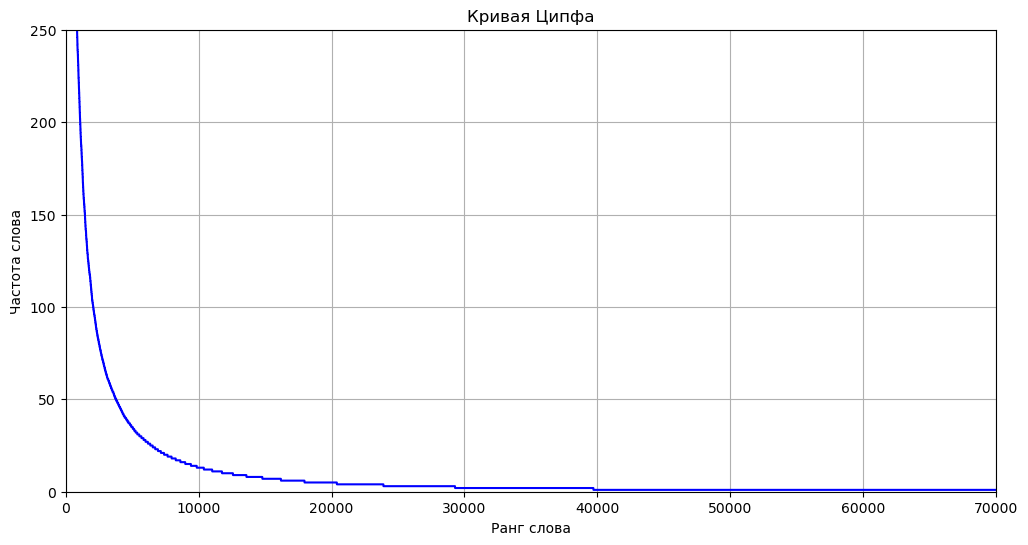

In [54]:
# Построение кривой Ципфа
plt.figure(figsize=(12, 6))

# Сортировка слов по убыванию частоты
sorted_word_freq = sorted(word_freq.values(), reverse=True)

# Построение кривой Ципфа
plt.plot(sorted_word_freq, color='blue')
ax = plt.gca()
ax.set_xlim([0, 70000])
ax.set_ylim([0, 250])
plt.title('Кривая Ципфа')
plt.xlabel('Ранг слова')
plt.ylabel('Частота слова')
plt.grid(True)
plt.show()

100%|███████████████████████████████████████████████████████████████████████████| 74904/74904 [01:56<00:00, 643.75it/s]


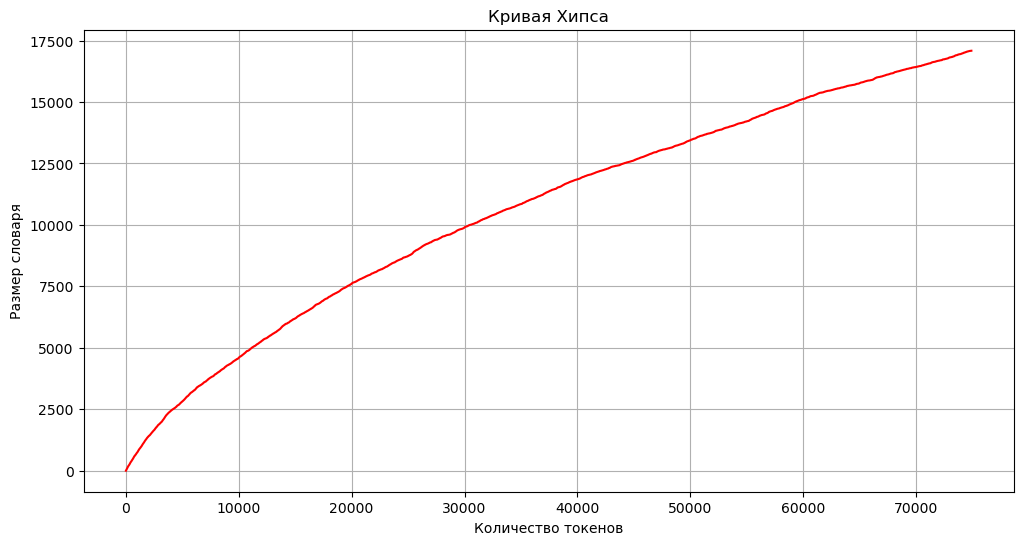

In [55]:
# Построение кривой Хипса
plt.figure(figsize=(12, 6))

# Создание списка уникальных слов для различных размеров корпуса
sizes = np.arange(1, len(sorted_word_freq) + 1)
vocab_sizes = [len(set(words[:size])) for size in tqdm(sizes)]

# Построение кривой Хипса
plt.plot(sizes, vocab_sizes, color='red')
plt.title('Кривая Хипса')
plt.xlabel('Количество токенов')
plt.ylabel('Размер словаря')
plt.grid(True)
plt.show()

#### 5. Ответьте на следующие вопросы:

##### - Какое слово встречается чаще "сотрудник" или "клиент"?

In [91]:
# Подсчитаем количество упоминаний слов "сотрудник" и "клиент"
count_employee = word_freq.get('сотрудник', 0)
count_client = word_freq.get('клиент', 0)
print(f'Количество упоминаний слова "сотрудник": {count_employee}')
print(f'Количество упоминаний слова "клиент": {count_client}')

Количество упоминаний слова "сотрудник": 2229
Количество упоминаний слова "клиент": 970


##### - Сколько раз встречается слово "мошенничество" и "доверие"?

In [92]:
# Подсчитаем количество упоминаний слов "мошенничество" и "доверие"
count_fraud = word_freq.get('мошенничество', 0)
count_trust = word_freq.get('доверие', 0)
print(f'Количество упоминаний слова "мошенничество": {count_fraud}')
print(f'Количество упоминаний слова "доверие": {count_trust}')

Количество упоминаний слова "мошенничество": 84
Количество упоминаний слова "доверие": 85


In [95]:
# Частота лемм искомых слов
# Подсчет частоты встречаемости слов "сотрудник" и "клиент"
word_freq = Counter(words)
count_employee = lemma_freq['сотрудник']
count_client = lemma_freq['клиент']

print(f'Слово "сотрудник" встречается {count_employee} раз')
print(f'Слово "клиент" встречается {count_client} раз')

# Подсчет количества вхождений слов "мошенничество" и "доверие"
count_fraud = lemma_freq['мошенничество']
count_trust = lemma_freq['доверие']

print(f'Слово "мошенничество" встречается {count_fraud} раз')
print(f'Слово "доверие" встречается {count_trust} раз')

Слово "сотрудник" встречается 9347 раз
Слово "клиент" встречается 7789 раз
Слово "мошенничество" встречается 219 раз
Слово "доверие" встречается 151 раз


#### 6. В поле 'rating_grade' записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграммы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [87]:
# Разделяем отзывы на положительные (оценка 5) и отрицательные (оценка 1)
positive_reviews = data_without_nan_city[data_without_nan_city['rating_grade'] == 5]['text']
negative_reviews = data_without_nan_city[data_without_nan_city['rating_grade'] == 1]['text']

In [88]:
# Создаем объект TfidfVectorizer для преобразования текстов в векторное представление
tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))

In [89]:
# Преобразуем положительные отзывы
tfidf_positive = tfidf_vectorizer.fit_transform(positive_reviews)

In [90]:
# Преобразуем отрицательные отзывы
tfidf_negative = tfidf_vectorizer.fit_transform(negative_reviews)

In [91]:
# Получаем список наиболее важных слов и биграмм для положительных отзывов
positive_feature_names = tfidf_vectorizer.get_feature_names_out()
positive_scores = tfidf_positive.sum(axis=0).A1
positive_keywords = [positive_feature_names[i] for i in positive_scores.argsort()[::-1][:10]]
print('Ключевые слова для положительных отзывах:', positive_keywords)

Ключевые слова для положительных отзывах: ['мои', 'на счет', 'что карта', 'перевода', '30', 'месте', 'же день', 'всё', '28', 'неделю']


In [92]:
# Получаем список наиболее важных слов и биграмм для отрицательных отзывов
negative_feature_names = tfidf_vectorizer.get_feature_names_out()
negative_scores = tfidf_negative.sum(axis=0).A1
negative_keywords = [negative_feature_names[i] for i in negative_scores.argsort()[::-1][:10]]
print('Ключевые слова для отрицательных  отзывах:', negative_keywords)

Ключевые слова для отрицательных  отзывах: ['не', 'на', 'что', 'мне', 'по', 'банка', 'банк', 'деньги', 'меня', 'как']


In [93]:
# Функция для токенизации, удаления стоп-слов и лемматизации текстов
def preprocess_text(text):
    words = nltk.word_tokenize(text.lower())
    words = [word for word in words if word.isalnum() and word.lower() not in stop_words]
    lemmas = [morph.parse(word)[0].normal_form for word in words]
    return lemmas

In [73]:
# Предварительная обработка положительных и отрицательных отзывов
preprocessed_positive_reviews = [' '.join(preprocess_text(review)) for review in positive_reviews]
preprocessed_negative_reviews = [' '.join(preprocess_text(review)) for review in negative_reviews]

In [74]:
# Создание векторизатора TF-IDF для биграмм
tfidf_vectorizer = TfidfVectorizer(ngram_range=(2, 2))

In [75]:
# Преобразование положительных отзывов
tfidf_positive = tfidf_vectorizer.fit_transform(preprocessed_positive_reviews)

In [76]:
# Получение биграмм из векторизатора
positive_feature_names = tfidf_vectorizer.get_feature_names_out()

In [83]:
# Получение лучших биграмм для положительных отзывов
top_positive_bigrams_idx = tfidf_positive.sum(axis=0).argsort()[:, ::-1][:, :10]

print('Ключевые биграммы для положительных отзывов:')
for idx in top_positive_bigrams_idx:
    print([positive_feature_names[i] for i in idx])

Ключевые биграммы для положительных отзывов:
[array([['сотрудник банк', 'кредитный карта', 'отделение банк',
        'клиент банк', 'дебетовый карта', 'добрый день',
        'хотеть выразить', 'другой банк', 'следующий день',
        'выразить благодарность']], dtype=object)]


In [78]:
# Преобразование отрицательных отзывов
tfidf_negative = tfidf_vectorizer.fit_transform(preprocessed_negative_reviews)

In [79]:
# Получение биграмм из векторизатора
negative_feature_names = tfidf_vectorizer.get_feature_names_out()

In [84]:
# Получение лучших биграмм для отрицательных отзывов
top_negative_bigrams_idx = tfidf_negative.sum(axis=0).argsort()[:, ::-1][:, :10]

print('Ключевые биграммы для отрицательных отзывов:')
for idx in top_negative_bigrams_idx:
    print([negative_feature_names[i] for i in idx])

Ключевые биграммы для отрицательных отзывов:
[array([['сотрудник банк', 'денежный средство', 'горячий линия',
        'кредитный карта', 'отделение банк', 'написать заявление',
        'добрый день', '2015 год', 'дебетовый карта', 'рабочий день']],
      dtype=object)]


### Часть 2. Тематическое моделирование

#### Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.

In [152]:
# Функция для предварительной обработки текста отзывов
def preprocess_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [morph.parse(word)[0].normal_form for word in tokens if word.isalnum() and word.lower() not in stop_words]
    return tokens

In [153]:
# Применим предварительную обработку к текстовым данным
data_without_nan_city['processed_text'] = data_without_nan_city['text'].apply(preprocess_text)

In [154]:
dictionary = corpora.Dictionary(data_without_nan_city['processed_text'])
corpus = [dictionary.doc2bow(text) for text in data_without_nan_city['processed_text']]

In [ ]:
lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

In [159]:
lda_model.show_topics()

[(0,
  '0.039*"банк" + 0.033*"кредит" + 0.019*"договор" + 0.016*"сумма" + 0.014*"кредитный" + 0.011*"год" + 0.011*"платёж" + 0.007*"сотрудник" + 0.007*"день" + 0.007*"страховка"'),
 (1,
  '0.033*"банк" + 0.014*"вклад" + 0.013*"карта" + 0.012*"клиент" + 0.007*"отделение" + 0.007*"офис" + 0.006*"время" + 0.005*"обслуживание" + 0.005*"сотрудник" + 0.005*"вопрос"'),
 (2,
  '0.035*"банк" + 0.019*"звонок" + 0.017*"номер" + 0.016*"сотрудник" + 0.014*"телефон" + 0.013*"мой" + 0.012*"звонить" + 0.012*"кредит" + 0.010*"ваш" + 0.008*"человек"'),
 (3,
  '0.033*"карта" + 0.022*"банк" + 0.020*"деньга" + 0.016*"день" + 0.011*"счёт" + 0.011*"отделение" + 0.010*"сказать" + 0.009*"заявление" + 0.008*"мой" + 0.008*"сумма"'),
 (4,
  '0.029*"банк" + 0.016*"средство" + 0.015*"счёт" + 0.012*"карта" + 0.011*"денежный" + 0.011*"мой" + 0.009*"услуга" + 0.008*"заявление" + 0.008*"сбербанк" + 0.008*"операция"')]

Примеры тем:
1. Оформление кредита
2. Открытие вклада
3. Звонки в службу поддержки
4. Оформление банковской карты
5. Денежные операции клиентов Сбербанка

### Часть 3. Классификация текстов

#### Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

##### 1. Составьте обучающее и тестовое множество
Выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.

In [41]:
# Разделяем отзывы на положительные (оценка 5) и отрицательные (оценка 1). Возьмём по 2000 отзывов каждого класса
neg_reviews = df[df['rating_grade'] == 1].sample(2000)
pos_reviews = df[df['rating_grade'] == 5].sample(2000)

In [45]:
# Объединим выбранные отзывы
selected_reviews = pd.concat([neg_reviews, pos_reviews], ignore_index=True)
selected_reviews.head(3)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Сбербанк не переводит деньги в Банк Москвы (с ...,23,лицензия № 1481,denk,Сбербанк России,2012-11-21 21:07:00,Добрый день! Сегодня сложилась такая ситуация ...,1.0
1,г. Новосибирск,False,Как МДМ любит своих клиентов...,10,лицензия № 323,Asesino,МДМ Банк,2010-12-28 10:17:00,Ничего положительного и отрицательного про МДМ...,1.0
2,г. Раменское,False,Беспредел сотрудников поражает!,2,лицензия № 2557,grant1110,Ситибанк,2013-02-20 16:21:00,Добрый день! 14 февраля сего года в аэропорту ...,1.0


In [47]:
# Разделим данные на обучающие и тестовые
X_train, X_test, y_train, y_test = train_test_split(selected_reviews['text'], 
                                                    selected_reviews['rating_grade'], 
                                                    test_size=0.2, 
                                                    random_state=42)

##### 2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline
Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных n
-грам.

In [68]:
# Векторизация текстовых данных с использованием различных подходов
vectorizer = CountVectorizer(ngram_range=(1, 1))  # Unigrams
# vectorizer = CountVectorizer(ngram_range=(2, 2))  # Bigrams
# vectorizer = CountVectorizer(ngram_range=(3, 3))  # Trigrams
# vectorizer = TfidfVectorizer(ngram_range=(1, 1))  # TF-IDF unigrams

In [69]:
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [70]:
# Обучение модели классификации
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

LogisticRegression()

In [71]:
# Оценка модели (unigrams)
y_pred = model.predict(X_test_vectorized)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.91      0.91      0.91       422
         5.0       0.90      0.90      0.90       378

    accuracy                           0.91       800
   macro avg       0.91      0.91      0.91       800
weighted avg       0.91      0.91      0.91       800



In [58]:
# Оценка модели (bigrams)
y_pred = model.predict(X_test_vectorized)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.90      0.86      0.88       422
         5.0       0.85      0.90      0.87       378

    accuracy                           0.88       800
   macro avg       0.88      0.88      0.87       800
weighted avg       0.88      0.88      0.88       800



In [62]:
# Оценка модели (trigrams)
y_pred = model.predict(X_test_vectorized)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.89      0.50      0.65       422
         5.0       0.63      0.93      0.75       378

    accuracy                           0.71       800
   macro avg       0.76      0.72      0.70       800
weighted avg       0.77      0.71      0.70       800



In [67]:
# Оценка модели (TF-IDF)
y_pred = model.predict(X_test_vectorized)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.93      0.94      0.93       422
         5.0       0.93      0.92      0.93       378

    accuracy                           0.93       800
   macro avg       0.93      0.93      0.93       800
weighted avg       0.93      0.93      0.93       800



##### 3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков
- 1-ый вариант: $tf-idf$ преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (sklearn.decomposition.TruncatedSVD);
- 2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation). Используйте accuracy и F-measure для оценки качества классификации.

In [133]:
# Определим pipeline для каждого варианта
pipeline_tfidf_lsi = Pipeline([
    ('vect', CountVectorizer(analyzer='word', max_df=0.75, ngram_range=(1, 1))),
    ('tfidf', TfidfTransformer()),
    ('tm', TruncatedSVD(n_components=75)),  
    ('clf', LogisticRegression(penalty='l2'))
])

In [153]:
pipeline_lda = Pipeline([
    ('vect', CountVectorizer(analyzer='word', max_df=0.75, ngram_range=(1, 1))),
    ('tfidf', TfidfTransformer()),
    ('tm', LatentDirichletAllocation(n_components=75)),
    ('clf', LogisticRegression())
])

In [163]:
# Обучение и оценка моделей
for pipeline, name in [(pipeline_tfidf_lsi, 'TF-IDF + LSI'), (pipeline_lda, 'LDA')]:
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy}")
    print(f"F1-score: {f1}")
    print("---")

Model: TF-IDF + LSI
Accuracy: 0.9075
F1-score: 0.9074396198940525
---
Model: LDA
Accuracy: 0.705
F1-score: 0.7041546213194771
---
